## Packages

In [3]:
#To install the dev version of statsmodels:
!pip install git+https://github.com/statsmodels/statsmodels

#To install yfiance:
!pip install yfinance

#To install the pyfinance:
!pip3 install pyfinance

#To install pandas market calendar:
!pip install pandas_market_calendars


  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-wwzp38_5
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-wwzp38_5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.13.0.dev0+129.gc02436998-cp36-cp36m-linux_x86_64.whl size=17738566 sha256=d4d0908b8de1cd12db0377a39e805ad0445e8d5b8fbd53da547d3f1409cb5425
  Stored in directory: /tmp/pip-ephem-wheel-cache-jyp2hhsa/wheels/7d/ad/45/ac1a03bd759c2fa74c486e2b1950d94b55f511b4c2b0418bd5
Successfully built statsmodels
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 5.5MB 6.8MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=a685952cf7e553464294d0ff76fbb6ceb764948ff7908dce74

In [165]:
## Import packages
import pandas as pd
import numpy as np
#from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import yfinance as yf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas_market_calendars as mcal
import logging
import math
import bs4 as bs
import pickle
import requests
import datetime as dt
import pandas_datareader.data as web
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller

## Find Pairs

In [205]:
#Pull Data

# tickers name preparation
def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        sector = row.findAll('td')[3].text
        ticker_sector = [ticker,sector]
        tickers.append(ticker_sector)

    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)

    return tickers


ticker_list = save_sp500_tickers()
ETF_list = ['XLC','XLY','XLP','XLE','XLF','XLV','XLI','XLK','XLB','XLRE','XLU']
df_b = pd.DataFrame(ticker_list, columns = ['ticker', 'sector'])
df_b.ticker = df_b.ticker.str.replace('\n','')
new_dict = (df_b.groupby('sector')
              .apply(lambda x: list(x.ticker))
              .to_dict())
new_dict.pop('Communication Services\n', None)
list_of_stocks = list(new_dict.items())
list_of_stocks_name = []
n = 0
for li in list_of_stocks:
  li[1].insert(0,ETF_list[n])
  list_of_stocks_name.append(li[1])
  n+=1



# get price data
def finance_data_for_tickers(ticker_list_fin, start, end):
  panel_data = web.DataReader(ticker_list_fin, 'yahoo', start, end)
  df_a = panel_data['Adj Close']
  df_a = df_a.dropna(axis='columns')
  return df_a

df_stock_price_list = []
# change formation period here
start = dt.datetime(2019, 7, 1)
end = dt.datetime(2020, 1, 1)
for stock_list in list_of_stocks_name:
  t = finance_data_for_tickers(stock_list, start, end)
  df_stock_price_list.append(t)

combined_stocks = pd.concat(df_stock_price_list, axis=1, sort=False)

/usr/local/lib/python3.6/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'LUMN', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/usr/local/lib/python3.6/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'BF.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/usr/local/lib/python3.6/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'BRK.B', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/usr/local/lib/python3.6/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'CARR', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/usr/local/lib/python3.6/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'OTIS', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/usr/local/lib/python3.6/dist-packages/pandas_datareader/base.py:272: SymbolWar

In [206]:
# find pairs
def find_cointegrated_pairs(data):
  n = data.shape[1]
  score_matrix = np.zeros((n,n))
  pvalue_matrix = np.ones((n,n))
  keys = data.keys()
  pairs = []
  for i in range(n):
    for j in range(i+1,n):
      s1 = data[keys[i]]
      s2 = data[keys[j]]
      result = coint(s1,s2)
      score = result[0]
      pvalue = result[1]
      score_matrix[i,j] = score
      pvalue_matrix[i,j] = pvalue
      if pvalue < 0.05:
        pairs.append((keys[i],keys[j]))
    return score_matrix,pvalue_matrix,pairs



# stationary test 
pairs_list = []
for i in range(len(ETF_list)):
  if ETF_list[i] in df_stock_price_list[i]:
    scores, pvalues, pairs = find_cointegrated_pairs(df_stock_price_list[i])
    pairs_list.append(pairs)

pairs_list = [i for i in pairs_list if i]
pairs_list_flatten = [i for j in pairs_list for i in j]

def spread_stationary_test(pair):
    etf_name = pair[0]
    stock_name = pair[1]
    etf = combined_stocks[etf_name]
    stock = combined_stocks[stock_name]
    model = sm.OLS(etf,stock).fit()
    spread = etf - model.params[0]*stock
    pvalue = adfuller(spread)[1]
    return pvalue

def find_pairs_stationary(pair_list):
    total_pairs = len(pair_list)
    new_pair_list = []
    for pair in pair_list:
      total_pairs-=1
      pvalue = spread_stationary_test(pair)
      if pvalue <0.05:
        new_pair_list.append(pair)
    return new_pair_list

stationary_pairs = find_pairs_stationary(pairs_list_flatten)

## Signal Construction

In [143]:
class Pair:
  # A pair consists of two stocks  
  # All dates should in string format "YYYY-MM-DD"

  def __init__(self, stock_ticker, etf_ticker, starttime="2020-01-01", endtime=datetime.today().strftime('%Y-%m-%d'), period='1d', interval=60):
    #constuctor
    self.stock = stock_ticker
    self.etf = etf_ticker
    self.start = starttime
    self.end = endtime
    self.period = period
    self.interval = interval

  def __getitem__(self, key):
    '''
    override index
    '''
    if key == 0:
      return self.stock
    if key == 1:
      return self.etf
    else:
      return

  def __repr__(self):
    '''
    string representation
    '''
    return ("(%s, %s)" %(self.stock, self.etf))
  
  def getData(self, startdate=None, enddate=None):
    #obtain adj close price for input tickers from yahoo finance
    ''' return a dataframe of tickers period return '''
    if startdate==None:
      startdate=self.start
    if enddate==None:
      enddate=self.end
    if startdate==self.start and enddate==self.end:
      print("getting all data from start to end")
    stockprice = yf.Ticker(self.stock).history(period=self.period, start=startdate, end=enddate)["Close"].rename(self.stock).pct_change().dropna()
    etfprice = yf.Ticker(self.etf).history(period=self.period, start=startdate, end=enddate)["Close"].rename(self.etf).pct_change().dropna()
    data = pd.concat([stockprice, etfprice], axis=1, sort=False)
    return data

  def regressor(self, date):
    #linear regression the stock return on etf return (1)
    ''' return array of resid of the regression '''
    #get past interval(default 60) market days from enddate
    nyse = mcal.get_calendar('NYSE')
    start_date = (datetime.strptime(date, '%Y-%m-%d') - timedelta(self.interval*2)).strftime('%Y-%m-%d')
    market_days = nyse.valid_days(start_date=start_date, end_date=date)[-self.interval:]
    start_date = datetime.strftime(market_days[0].date(), '%Y-%m-%d')

    returns = self.getData(startdate = start_date, enddate = date)
    endog = returns.iloc[:, 0].values  #y
    exog = sm.add_constant(returns.iloc[:, 1].values) #add intercept to x
    mod = sm.OLS(endog=endog, exog=exog)
    model = mod.fit()
    return model.resid

  def X(self, date):
    #create auxiliary process X (2) 
    ''' return array of process X '''
    resid = self.regressor(date = date)
    X = np.zeros(len(resid))
    X[0] = resid[0]
    for i in range(1,len(resid)):
      X[i] = X[i-1] + resid[i]
    return X

  def AutoRegressor(self, date):
    #AR(1) on the process X (3)
    ''' return tupel(a,b,k,sigma_eq) '''
    armod = AutoReg(self.X(date = date), lags=1, old_names = False, missing = 'drop')
    armodel = armod.fit()
    a = armodel.params[0]
    b = armodel.params[1]
    k = -np.log(b)*252
    variance = np.var(armodel.resid)
    sigma_eq = np.sqrt(variance / (1 - b**2))
    return (a,b,k,sigma_eq)

  def detail(self, date=datetime.today().strftime('%Y-%m-%d')):
    #Print details of OU parameters (4)(5) 
    ''' return none '''
    result = self.AutoRegressor(date = date)
    a = result[0]
    b = result[1]
    k = result[2]
    sigmaeq = result[3]
    sigma = result[3] * np.sqrt(2*k)
    s = -(result[0] / (1 - result[1])) / result[3]
    tau = 1/k*252
    if date==datetime.today().strftime('%Y-%m-%d'):
      print("S-Score at market close on Date: %s \n" 
            %(yf.Ticker(self.stock).history(period="1d", start=(datetime.today() - timedelta(1)).strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))["Close"].index[-1].strftime('%Y-%m-%d')))
    print("a=%f, b=%f, k=%f, sigma=%f, sigma equilibrium=%f, reversion days=%f, S-score=%f" %(a,b,k,sigma,sigmaeq,tau,s))
    return

  def calcScore(self, date=datetime.today().strftime('%Y-%m-%d')):
    #Gives S-Score of the date, calling without input gives today's S-score (6)
    ''' return float S-score '''
    result = self.AutoRegressor(date = date)
    m = result[0] / (1 - result[1])
    s = -m / result[3]
    if date==datetime.today().strftime('%Y-%m-%d'):
      print("Calculated S-Score at market close on Date: %s \r" 
            %(yf.Ticker(self.stock).history(period="1d", start=(datetime.today() - timedelta(1)).strftime('%Y-%m-%d'), end=datetime.today().strftime('%Y-%m-%d'))["Close"].index[-1].strftime('%Y-%m-%d')))
    return s
  
  def rolling(self):
    #calcualte S scores from start date to end date
    ''' return list of S scores '''
    date = self.start
    Sscore = []
    while(datetime.strptime(date, '%Y-%m-%d').strftime('%Y-%m-%d') != self.end):
      Sscore.append(self.calcScore(date = date))
      date = (datetime.strptime(date, '%Y-%m-%d') + timedelta(1)).strftime('%Y-%m-%d')
    Sscore.append(self.calcScore(date = (datetime.strptime(date, '%Y-%m-%d') + timedelta(1)).strftime('%Y-%m-%d')))
    return Sscore
  
  def plot(self):
    ''' plot S scores calculated in the rolling method''' 
    scores = self.rolling()
    Scores = pd.DataFrame(scores, columns=["S-Score"], index=pd.date_range(start=self.start, end=self.end, freq='D'))
    plt.figure(figsize=(20,10))
    Scores.plot()
    return

## Back Testing

In [160]:
class Portfolio: 
  # store all information
  def __init__(self, capital):
    # book[(str)ticker] = [(str)ticker, (str)'long'/'short', (int)shares holding, (double)total value of position at purchase time, (int)pair index it belongs to ]
    self.book = {} # to store all current positions, keys=index of pairs, values=position in dollar
    self.capital = [capital] #total value of portfolio as a list, record everyday
    self.cash = [0.8*capital] #avaliable capital to invest as a list, record everyday
    self.marginaval = [0.2*capital] #avaliable capital secured for margin account, record everyday
    self.marginacc = [0] #margin account, record everyday 
    self.history = [] #store all transcation history
    #self.#TODO add more things

  def newday(self):
    '''
    append a number as yesterday for recording today's trasaction on capital, cash, marginaval, marginacc
    '''
    self.capital.append(self.capital[-1])
    self.cash.append(self.cash[-1])
    self.marginaval.append(self.marginaval[-1])
    self.marginacc.append(self.marginacc[-1])

  def position_pair_index(self):
    '''
    return: (list of int) list of pair indices that currently have positions
    '''
    values = self.book.values()
    indices = []
    for i in values:
      indices.append(i[-1])
    index = []
    for i in indices: # remove duplicates
      if i not in index: 
        index.append(i)

    return index
    
  def port_return(self):
    '''return daily portfolio return'''
    a = pd.DataFrame(self.capital).shift(1)/pd.DataFrame(self.capital)
    returns = a.dropna().values.tolist()
    return returns

  def largest_drawdown_ratio(self):
    '''return largest withdraw ratio'''
    # use self.capital ,which records total capital everyday
    max_capital = np.maximum.accumulate(self.capital)
    x = np.argmax((max_capital - self.capital)/max_capital)
    y = np.argmax(self.capital[:x])
    return (self.capital[y] - self.capital[x])/(self.capital[y])

  def sharpe_ratio(self):
    '''return (annual) sharpe ratio'''
    #average_return = np.mean(self.port_return())
    #return_stdev = np.std(self.port_return())

    return (self.capital[-1]-self.capital[0]) / self.capital[0] /(return_stdev*math.sqrt(252))

  def plot_capital(self):
    '''plot capital trend'''
    # plot self.capital
    plt.plot(self.capital)
    return

  def plot_cash(self):
    '''plot capital trend'''
    # plot self.cash
    plt.plot(self.cash)
    return


  #def #TODO add more things

In [155]:
class Backtester:

  def __init__(self, algorithm='Mean-Reversion Pairs', start_date='2020-01-01', end_date='2020-12-01', pairs=[('JPM', 'XLF')], period='1d', capital=100000,
               formation_start_date = "2020-01-01", formation_end_date = "2020-12-01", s = 2):
    self._logger = logging.getLogger(__name__)
    self.port = Portfolio(capital) #Portfolio object
    self.algo = algorithm #string
    self.start_date = start_date #string
    self.end_date = end_date #string
    self.pair = pairs # list of tupels [(stock1,ETF1), (stock2,ETF2)]
    self.period = period # int 
    self.capital = capital
    self.formation_start_date = formation_start_date 
    self.formation_end_date = formation_end_date
    self.s = s

    #obtain historical price data in one dataframe
    self.tickers = [] # list of strings
    for i in self.pair:
      self.tickers.append(i[0])
      self.tickers.append(i[1])
      print("acquired pair %s , %s" %(i[0], i[1]))
    self.data = yf.Tickers(self.tickers).history(period=period, start=self.start_date, end=self.end_date)["Close"] #download all historical data of pairs
    self.returns = self.data.pct_change().dropna()

    #form instances of pairs in list
    self.pairsname = [] # list of tupel of strings
    self.pairs = [] # list of tuples of Pair objects
    for i in self.pair:
      self.pairsname.append((i[0], i[1]))
      #use index to identify pairs in trading
      self.pairs.append(Pair(i[0], i[1]))

    #compute inverse volatility weights
    #compute list of pairs' betas
    self.betas = []
    for i in range(len(self.pairsname)):
        self.betas.append((self.get_beta(self.pairsname[i][0], formation_end_date, 365), self.get_beta(self.pairsname[i][1], formation_end_date, 365)))
    #compute weights inside each pair
    self.pair_weights = []
    for i in self.betas:
        stock_dollar_amount = i[1] / i[0]
        port_value = stock_dollar_amount - 1
        self.pair_weights.append((stock_dollar_amount / port_value, -1 / port_value))
        
    #compute annualizd volatility for each stock and etf
    self.pairs_vol = []
    for i in self.pairsname:
        self.pairs_vol.append((self.get_vol(i[0], formation_start_date, formation_end_date), self.get_vol(i[1], formation_start_date, formation_end_date)))
    
    #compute volatility for each pair
    self.pair_vol = []
    for i in range(len(self.pair_weights)):
        self.pair_vol.append((self.pair_weights[i][0] ** 2) * (self.pairs_vol[i][0] ** 2) + (self.pair_weights[i][1] ** 2) * (self.pairs_vol[i][1] ** 2) + 2 * self.pair_weights[i][0] * self.pair_weights[i][1] * self.get_cov(self.pairsname[i][0], self.pairsname[i][1], formation_start_date, formation_end_date))
    
    #compute weights
    self.weights = []
    for i in range(len(self.pair_vol)):
        self.weights.append(1 / self.pair_vol[i])
    self.weights = [i / sum(self.weights) for i in self.weights]

    #fix order size by the weight
    self.order_sizes = [i * 0.7 * self.capital for i in self.weights] 

  def print_data(self, number=5):
    print(self.data.head(number))
    return

  def get_beta(self, stock, today_date, period=60):
    '''
    return: (float) beta of stock vs market(S&P500)
    '''
    nyse = mcal.get_calendar('NYSE')
    start_date = (datetime.strptime(today_date, '%Y-%m-%d') - timedelta(period*2)).strftime('%Y-%m-%d')
    market_days = nyse.valid_days(start_date=start_date, end_date=today_date)[-period:]
    start_date = datetime.strftime(market_days[0].date(), '%Y-%m-%d')

    returns = yf.Tickers([stock, 'SPY']).history(period='1d', start=start_date, end=today_date)["Close"].pct_change().dropna()
    endog = returns.iloc[:, 0].values  #y
    exog = sm.add_constant(returns.iloc[:, 1].values) #add intercept to x
    mod = sm.OLS(endog=endog, exog=exog)
    model = mod.fit()
    return model.params[1]

  def get_vol(self, ticker, start_date, end_date):
    formation_returns = yf.Tickers(self.tickers).history(period=self.period, start=start_date, end=end_date)["Close"].pct_change().dropna()#[start_date:end_date]
    #formation_returns = self.returns[start_date:end_date]
    return np.std(formation_returns[ticker])
  
  def get_cov(self,ticker1, ticker2, start_date, end_date):
    formation_returns = yf.Tickers(self.tickers).history(period=self.period, start=start_date, end=end_date)["Close"].pct_change().dropna()
    #formation_returns = self.returns[start_date:end_date]
    return formation_returns[ticker1].cov(formation_returns[ticker2])

  def rebalance(self, today_date, limited_data):
    '''
    update portfolio total value everyday
    Return: None
    '''
    cashvalue = self.port.cash[-1]
    marginbalance = self.port.marginacc[-1]
    marginreserve = self.port.marginaval[-1]
    positionvalue = 0
    for i in self.port.book.keys():
      if (self.port.book[i][1] == 'long'):
        positionvalue += (self.port.book[i][2] * limited_data[i][-1])
      if (self.port.book[i][1] == 'short'):
        positionvalue -= (self.port.book[i][2] * limited_data[i][-1])
    self.port.capital[-1] = (cashvalue + marginbalance + positionvalue + marginreserve)
    #update your order sizes accordingly
    #self.order_sizes = [i * self.port.cash[-1] for i in self.weights] #dynamically adjust based on cash left
    self.order_sizes = [i * 0.7 * self.port.capital[-1] for i in self.weights] #dynamically ajust based on current capital
    return

  def buy(self, stock, index, dollar, today_date, limited_data):
    '''
    Buy certain stock for given amount of dollar at today's close price (and update portfolio accordingly)
    Return: True if transaction completed
            False if transaction failed
    '''
    price_per_share = limited_data[stock][-1]
    print("Buy %s for $ %i at $ %i" %(stock, dollar, price_per_share))
    #sllipage
    trade_price = price_per_share * (1 + np.random.normal(0,0.002))
    max_shares_buy = dollar // trade_price
    if self.port.cash[-1] >= max_shares_buy*trade_price:
      # current position saved to book
      self.port.book[stock] = [stock, 'long', max_shares_buy, max_shares_buy*trade_price, index]  #book[ticker] = [ticker, long/short, shares holding, total value of position, pair index]
      # update cash avaliable
      self.port.cash[-1] -= max_shares_buy*trade_price
      # deduct commision / transaction cost
      self.port.cash[-1] -= max(2.99,0.01*max_shares_buy)
      #self.port.capital[-1] -= min(2.99,0.01*max_shares_buy)
      # store to transaction history
      self.port.history.append([stock, 'buy', max_shares_buy, max_shares_buy*trade_price])
      return True
    else: 
      print('Insufficient Cash Buying!')
    return False

  def shortsell(self, stock, index, dollar, today_date, limited_data):
    '''
    Short sell certain stock for given amount of dollar at today's close price (and update portfolio accordingly)
    Return: True if transaction completed
            False if transaction failed
    '''
    # Short selling assumes 100% margin deposit 
    price_per_share = limited_data[stock][-1]
    print("Short sell %s for $ %i at $ %i" %(stock, dollar,price_per_share))
    #sllipage
    trade_price = price_per_share * (1 + np.random.normal(0,0.002))
    max_shares_sell = dollar // trade_price
    if (self.port.cash[-1]) >= -10000000:
      # current position saved to book
      self.port.book[stock] = [stock, 'short', max_shares_sell, max_shares_sell*trade_price, index]  #book[ticker] = [ticker, long/short, shares holding, total value of position, pair index]
      # update cash avaliable
      self.port.cash[-1] -= max_shares_sell*trade_price #you need to transfer this amount to margin
      self.port.cash[-1] += max_shares_sell*trade_price #then you sell the stock, you get some money
      # move cash to margin account
      self.port.marginacc[-1] += max_shares_sell*trade_price
      # deduct commision / transaction cost
      self.port.cash[-1] -= max(2.99,0.01*max_shares_sell)
      #self.port.capital[-1] -= min(2.99,0.01*max_shares_sell)
      # store to transaction history
      self.port.history.append([stock, 'short sell', max_shares_sell, max_shares_sell*trade_price])
      return True
    else: 
      print('Insufficient Cash Short Selling!')
      print(self.port.cash[-1])
    return False

  def longsell(self, stock, today_date, limited_data):
    '''
    Sell certain stock we currently own for given amount of dollar at today's close price (and update portfolio accordingly)
    Return: True if transaction completed
            False if transaction failed
    '''
    print("Long sell %s at $ %i" %(stock, limited_data[stock][-1]))
    #retrieve our current position for stock
    curr_pos = self.port.book[stock]
    shares = curr_pos[2]
    #sell at today's close, include sllipage...
    sell_price = limited_data[stock][-1] * (1 + np.random.normal(0,0.002))
    sell_amount = shares * sell_price
    #remove from portfolio book
    self.port.book.pop(stock)
    #update portfolio include transaction cost...
    self.port.cash[-1] += sell_amount
    #self.port.capital[-1] += (sell_amount - curr_pos[3])
    #self.port.capital[-1] -= min(2.99,0.01*shares)
    self.port.cash[-1] -= max(2.99,0.01*shares)
    # store to transaction history
    self.port.history.append([stock, 'long sell', shares, sell_amount])
    return True

  def buyback(self, stock, today_date, limited_data):
    '''
    Buy back certain stock that we currently short sold for given amount of dollar at today's close price (and update portfolio accordingly)
    Return: True if transaction completed
            False if transaction failed
    '''
    print("Buy back %s at $ %i" %(stock, limited_data[stock][-1]))
    #retrieve our current position for stock
    curr_pos = self.port.book[stock]
    shares = curr_pos[2]
    #buy at today's close, include sllipage...
    buy_price = limited_data[stock][-1] * (1 + np.random.normal(0,0.002))
    buy_amount = shares * buy_price
    #remove from portfolio book
    self.port.book.pop(stock)
    #get cash back from marginacc
    self.port.cash[-1] += curr_pos[3]
    self.port.marginacc[-1] -= curr_pos[3]
    #check for gain/loss, update capital
    self.port.cash[-1] -= buy_amount
    #transaction cost
    #self.port.capital[-1] -= min(2.99,0.01*shares)
    self.port.cash[-1] -= max(2.99,0.01*shares)
    # store to transaction history
    self.port.history.append([stock, 'buy back', shares, buy_amount])
    return True


  def open_position(self, indices, today_date, limited_data):
    #Check for type of trade: long stock short ETF or short stock long ETF
    '''
    Open positions for a list of pairs that have signal for trade
    '''
    print('------------------------------------------------')
    print("TRY TO OPEN A POSITION , DATE: %s" %today_date)
    pairs = [self.pairs[i] for i in indices]
    print("pairs: ")
    print([i for i in pairs])
    print("S Score")
    print([i.calcScore(today_date) for i in pairs])
    order_sizes = [self.order_sizes[i] for i in indices]
    print("corresponding allowed order sizes in dollar: ")
    print(order_sizes)
    print("cash aval:")
    print(self.port.cash[-1])
    pairsbeta = []
    longshortratios = []
    #for each pair, calculate stock beta and etf beta to make pair beta neutral
    for i in pairs:
      pairsbeta.append((self.get_beta(i[0], today_date, period = 60), self.get_beta(i[1], today_date, period = 60)))
    print("pair's betas: ")
    print(pairsbeta)
    longshortratios = [i[0]/i[1] for i in pairsbeta]  #this ratio gives a list of doubles that for short/long each 1 dollor stock, we need to long/short the ETF to maintain market neutral.
      
    if min([i.calcScore(today_date) for i in pairs]) > self.s: #short stock long ETF
      #for each pair, do long short order given constrain on order size and long short ratios
      for i in pairs:
        #short sell stock， you short for inverse longshortratio * order size to maintain beta neutral, since you get money from shortselling to pay for margin deposit
        transaction1 = self.shortsell(i[0], indices[pairs.index(i)], (1/longshortratios[pairs.index(i)])*order_sizes[pairs.index(i)], today_date, limited_data)
        #buy etf, spend all allocated order size on long
        #to match two transactions, if first fails, then ignore then second:
        transaction2 = False
        if transaction1:
          transaction2 = self.buy(i[1], indices[pairs.index(i)], order_sizes[pairs.index(i)], today_date, limited_data)
        if (transaction1 == transaction2):
          "Transaction success"
        if (transaction1 != transaction2):
          "ERROR: Long Short Fail to Match!"

    elif max([i.calcScore(today_date) for i in pairs]) < -self.s: #long stock short ETF
      #for each pair, do long short order given constrain on order size and long short ratios
      for i in pairs:
        #buy stock for the ordersize dollar
        transaction1 = self.buy(i[0], indices[pairs.index(i)], order_sizes[pairs.index(i)], today_date, limited_data)
        #short sell etf for the longshort ratio * order size dollar since assume in short selling you sell the stock you get money back to pay margin deposit
        #to match two transactions, if first fails, then ignore then second:
        transaction2 = False
        if transaction1:
          transaction2 = self.shortsell(i[1], indices[pairs.index(i)], longshortratios[pairs.index(i)]*order_sizes[pairs.index(i)], today_date, limited_data)
        if (transaction1 == transaction2):
          "Transaction success"
        if (transaction1 != transaction2):
          "ERROR: Long Short Fail to Match!"
    else:
      print("Something bad happen when opening position, your S-Score might be wrong")
    print(self.port.book)
    return

  def close_position(self, indices, today_date, limited_data):
    # make sure we indeed have a 
    print('------------------------------------------------')
    print("TRY TO CLOSE A POSITION , DATE: %s" %today_date)
    pairs = [self.pairs[i] for i in indices]
    print("pairs: ")
    print([i for i in pairs])
    print("S Score")
    print([i.calcScore(today_date) for i in pairs])
    print(self.port.book)
    print("cash aval:")
    print(self.port.cash[-1])
    for i in pairs:
      if ((i[0] in self.port.book.keys())==False):
        print("ERROR: Given index currently does not have a position")
      if ((i[1] in self.port.book.keys())==False):
        print("ERROR: Given index currently does not have a position")
    # for each pairs:
    for i in pairs:
      # for each stock/etf in pair:
      for j in range(0,2):
        transaction = False
        if (self.port.book[i[j]][1] == 'long'): # sell it!
          transaction = self.longsell(i[j], today_date, limited_data)
        elif (self.port.book[i[j]][1] == 'short'): # buy it back!
          transaction = self.buyback(i[j], today_date, limited_data)
        else:
          print('cannot determine long or short position')
        if transaction == False:
          print('ERROR: Something bad happened when close position')
    return

  def trade(self, today_date, limited_data):
    # put a new day in our portfolio
    self.port.newday()
    # calculate s-score and make transactions and update portfolio in this function
    s_scores = [i.calcScore(today_date) for i in self.pairs]
    
    # CLOSE POSITION: check for signals of existing positions (-0.5 < s_scores < 0.5)
    pairs_w_position = self.port.position_pair_index() 
    reversed_s = [idx for idx, val in enumerate([self.pairs[i].calcScore(today_date) for i in pairs_w_position]) if -0.5<val<0.5]  # give the pair index than have reached bar for close position
    reversed_s_indices = [pairs_w_position[i] for i in reversed_s] 

    # check if reversed_s_indices is empty:
    if reversed_s_indices:
      self.close_position(reversed_s_indices, today_date, limited_data) 

    # OPEN POSITION: check for signals (s_scores > s or s_scores < s), get all indices of which have s-scores > s (input bar)
    large_s_indices = [idx for idx, val in enumerate(s_scores) if val > self.s]  # give the pair index that reached bar for open position
    small_s_indices = [idx for idx, val in enumerate(s_scores) if val < -self.s] # give the pair index that reached bar for open position
    # check for pairs that have exsiting position, remove from indices
    large_s_indices = [elem for elem in large_s_indices if elem not in self.port.position_pair_index()]
    small_s_indices = [elem for elem in small_s_indices if elem not in self.port.position_pair_index()]

    # check if large_s_indices and small_s_indices is empty:
    if large_s_indices:
      self.open_position(large_s_indices, today_date, limited_data) #short stock, long ETF
    if small_s_indices:
      self.open_position(small_s_indices, today_date, limited_data) #long stock, short ETF

    self.rebalance(today_date, limited_data)  #update portfolio capital total value (position value + cash + marginacc balance), even in the case of no trading happen
  
        
  def backtest(self):
    if self.algo == 'Mean-Reversion Pairs':
      for i in range(0,len(self.data)):
        today_date = self.data.index[i].strftime('%Y-%m-%d') #obtain today's date
        limited_data = self.data[:i+1] #limite data to prevent future information (limited data includes today's close)
        self.trade(today_date, limited_data)
    print('----------------SUMMARY-----------------------')
    print('BACKTEST PERIOD: %s to %s' %(self.start_date, self.end_date))
    print('TRADING PAIRS %s' %self.pairs)
    print('START CAPITAL: %i' %self.capital)
    print('END CAPITAL: %i' %self.port.capital[-1])
    print('RETURN: %f' %((self.port.capital[-1] - self.capital) / self.capital))
    return self.port
        
        
        

    

## Analysis

In [207]:
stationary_pairs

[('XLV', 'JNJ'), ('XLK', 'AVGO')]

<Figure size 1440x720 with 0 Axes>

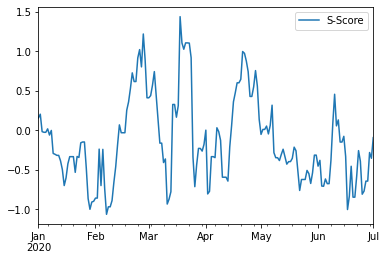

In [185]:
Pair('ANSS', 'XLK', '2020-01-01', '2020-07-01').plot()

In [213]:
b = Backtester(algorithm='Mean-Reversion Pairs', start_date='2020-07-01', end_date='2020-12-01', 
               pairs=[('GOOGL','XLC'), ('PXD','XLE'), ('RJF','XLF'), ('DOV', 'XLI'), ('ANSS', 'XLK')], 
               period='1d', capital=100000,
               formation_start_date = "2020-01-01", formation_end_date = "2020-07-01")
result = b.backtest()

acquired pair GOOGL , XLC
acquired pair PXD , XLE
acquired pair RJF , XLF
acquired pair DOV , XLI
acquired pair ANSS , XLK
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%*******************

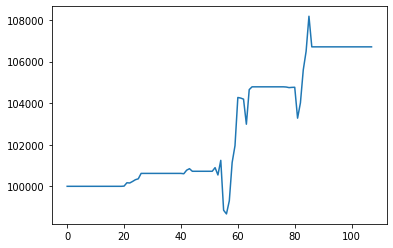

In [214]:
plt.plot(b.port.capital)

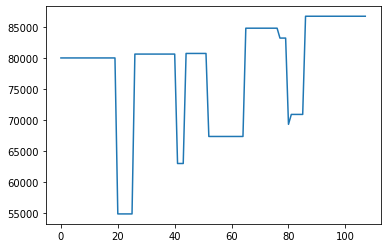

In [215]:
plt.plot(b.port.cash)

In [216]:
#shape ratio
(((result.capital[-1] - result.capital[0]) / result.capital[0] + 1)**2 - 1) / (np.std(result.port_return())*math.sqrt(252))

1.665892998324645

In [217]:
#largest drawdown
result.largest_drawdown_ratio()

0.025456002474563953